# Ironhack Final Bootcamp Project - Spaceship Titanic (Kaggle)

This project is based on the Kaggle Spaceship Titanic competition. It consists on a binary classification machine learning model, wich has the objective to predict the if a whether a person will be transported to an alternate dimension or not.

## Data Cleaning

###  Importing libraries and quick overview on dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE, SelectKBest, chi2
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc

In [2]:
train_data = pd.read_csv('../data/train.csv')
test_data = pd.read_csv('../data/test.csv')
submission_sample = pd.read_csv('../data/sample_submission.csv')

In [3]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


Here you can see the description of each column:

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [5]:
print('train_data shape',train_data.shape)
print('test_data shape', test_data.shape)

# the test_data has one less column, wich is target column i need to predict

train_data shape (8693, 14)
test_data shape (4277, 13)


In [6]:
train_data.info()
# there are some nulls, i'll need to take a look at each collumn in specific to choose the best strategy to deal with it

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [8]:
train_data['PassengerId'].head(10)
# the column PassengerID has two informations, the group the passenger is travelling with, and the 
# number of the passenger within the group. i'll do feature engineering to extract some useful information.

0    0001_01
1    0002_01
2    0003_01
3    0003_02
4    0004_01
5    0005_01
6    0006_01
7    0006_02
8    0007_01
9    0008_01
Name: PassengerId, dtype: object

In [9]:
train_data['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [10]:
train_data['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

In [11]:
type(train_data['CryoSleep'][0])

bool

In [12]:
train_data['Cabin'].head(10)
# the column Cabin has three informations, deck, number and side of the cabin
# i'll do feature engineering to extract some useful information.

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
5    F/0/P
6    F/2/S
7    G/0/S
8    F/3/S
9    B/1/P
Name: Cabin, dtype: object

In [13]:
train_data['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

In [14]:
train_data['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

In [15]:
train_data['Name'].nunique()
# I'll drop the column Name, since it has such a high number of different values and it might not have correlation with target

8473

In [16]:
train_data['Transported'].value_counts()
# the train_data is almost exactly balanced, so there will be no need to worry about upsampling or downsampling in this case

True     4378
False    4315
Name: Transported, dtype: int64

In [17]:
type(train_data['VIP'][0])

bool

In [18]:
# using the bool columns as categoricals

train_data['Transported'] = train_data['Transported'].replace({True: 'True', False: 'False'})
train_data['VIP'] = train_data['VIP'].replace({True: 'True', False: 'False'})
test_data['VIP'] = test_data['VIP'].replace({True: 'True', False: 'False'})
train_data['CryoSleep'] = train_data['CryoSleep'].replace({True: 'True', False: 'False'})
test_data['CryoSleep'] = test_data['CryoSleep'].replace({True: 'True', False: 'False'})

In [19]:
# null values in train and test sets

print('Percentage of nulls in Train Data', '\n',train_data.isna().sum()/len(train_data) * 100,'\n')
print('Percentage of nulls in Test Data', '\n',test_data.isna().sum()/len(test_data) * 100)

Percentage of nulls in Train Data 
 PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64 

Percentage of nulls in Test Data 
 PassengerId     0.000000
HomePlanet      2.034136
CryoSleep       2.174421
Cabin           2.338087
Destination     2.151040
Age             2.127660
VIP             2.174421
RoomService     1.917232
FoodCourt       2.478373
ShoppingMall    2.291326
Spa             2.361468
VRDeck          1.870470
Name            2.197802
dtype: float64


### Feature Engineering

In [20]:
train_data['PassengerId']
# i'll do feature engineering to extract the size of the group the passenger belongs

0       0001_01
1       0002_01
2       0003_01
3       0003_02
4       0004_01
         ...   
8688    9276_01
8689    9278_01
8690    9279_01
8691    9280_01
8692    9280_02
Name: PassengerId, Length: 8693, dtype: object

In [21]:
def fe_group_size(df):
    # creating new columns to separate the two informations inside the column PassengerId
    df['GroupNumber'] = list(map(lambda x: int(x.split('_')[0]), df['PassengerId']))
    df['PassengerNumber'] = list(map(lambda x: int(x.split('_')[1]), df['PassengerId']))
    
    # i'll create the column GroupSize with nulls inside it
    df['GroupSize'] = np.nan
    
    # getting the number of passengers inside each group and fill the nulls using a for loop
    for i in range(len(df)):
        df['GroupSize'][i] = df[df['GroupNumber'] == df['GroupNumber'][i]]['PassengerNumber'].sort_values(ascending=False).values[0]
        
    return df

In [22]:
# applying the function to both datasets
train_data = fe_group_size(train_data)
test_data = fe_group_size(test_data)
# now both datasets have tree more columns: GroupNumber, PassengerNumber and GroupSize

In [23]:
for i in range(1,20):
    print(f'number of passengers in group number {i}:', len(train_data[train_data['GroupNumber'] == i]))
    
# I don't think the column GroupNumber is a good input to the machine learning model. It has to many different values
# with just a few records. I don't think the algorithm will be able to learn anything with it.
# Instead of droping this column i'll create buckets to aggregate data.

number of passengers in group number 1: 1
number of passengers in group number 2: 1
number of passengers in group number 3: 2
number of passengers in group number 4: 1
number of passengers in group number 5: 1
number of passengers in group number 6: 2
number of passengers in group number 7: 1
number of passengers in group number 8: 3
number of passengers in group number 9: 1
number of passengers in group number 10: 1
number of passengers in group number 11: 1
number of passengers in group number 12: 1
number of passengers in group number 13: 0
number of passengers in group number 14: 1
number of passengers in group number 15: 1
number of passengers in group number 16: 1
number of passengers in group number 17: 2
number of passengers in group number 18: 0
number of passengers in group number 19: 0


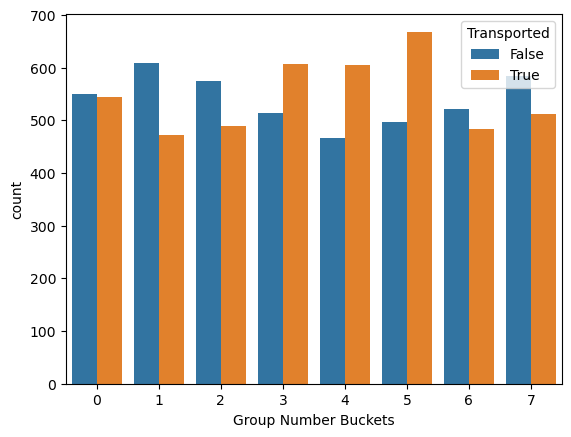

In [24]:
group_number_buckets = pd.cut(train_data['GroupNumber'], bins=8, labels=False)

sns.countplot(x=group_number_buckets, hue=train_data['Transported'])
plt.xlabel('Group Number Buckets')
plt.show()

In [25]:
train_data['Cabin'].head()
# Now i'll work on the column Cabin. It has three informations: deck, number and side

0    B/0/P
1    F/0/S
2    A/0/S
3    A/0/S
4    F/1/S
Name: Cabin, dtype: object

In [26]:
def fe_cabin(df):
    # creating new columns to separate the information inside the column Cabin
    df['CabinDeck'] = list(map(lambda x: np.nan if type(x)==float else x.split('/')[0], df['Cabin']))
    df['CabinNumber'] = list(map(lambda x: np.nan if type(x)==float else int(x.split('/')[1]), df['Cabin']))
    df['CabinSide'] = list(map(lambda x: np.nan if type(x)==float else x.split('/')[2], df['Cabin']))
    # i used if else to avoid nulls
    
    # droping Cabin since the information is now in three new columns
    df = df.drop('Cabin', axis=1)

    return df

In [27]:
train_data = fe_cabin(train_data)
test_data = fe_cabin(test_data)

In [28]:
for i in range(20):
    print(f'number of passengers in a cabin with number {i}:', len(train_data[train_data['CabinNumber'] == i]))

number of passengers in a cabin with number 0: 18
number of passengers in a cabin with number 1: 15
number of passengers in a cabin with number 2: 11
number of passengers in a cabin with number 3: 16
number of passengers in a cabin with number 4: 7
number of passengers in a cabin with number 5: 13
number of passengers in a cabin with number 6: 12
number of passengers in a cabin with number 7: 9
number of passengers in a cabin with number 8: 13
number of passengers in a cabin with number 9: 16
number of passengers in a cabin with number 10: 12
number of passengers in a cabin with number 11: 16
number of passengers in a cabin with number 12: 5
number of passengers in a cabin with number 13: 16
number of passengers in a cabin with number 14: 16
number of passengers in a cabin with number 15: 10
number of passengers in a cabin with number 16: 17
number of passengers in a cabin with number 17: 8
number of passengers in a cabin with number 18: 18
number of passengers in a cabin with number 1

In [29]:
# since the number of passengers for each CabinNumber is so low, i don't think the machine learning model
# will be able to understand this column really well. I'll create buckets to aggregate data

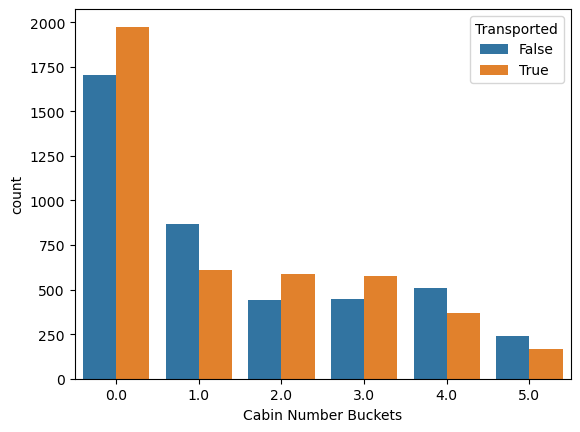

In [30]:
cabin_number_buckets = pd.cut(train_data['CabinNumber'], bins=6, labels=False)

sns.countplot(x=cabin_number_buckets, hue=train_data['Transported'])
plt.xlabel('Cabin Number Buckets')
plt.show()

In [31]:
def bucketing(df):
    # creating the bucket names using a for loop and list comprehension
    bucket_names_8 = [f'Bucket {i}' for i in range(8)]
    bucket_names_6 = [f'Bucket {i}' for i in range(6)]
    
    # creating column GroupNumberBucket
    df['GroupNumberBuckets'] = pd.cut(df['GroupNumber'], bins=8, labels=bucket_names_8)
    
    # creating column CabinNumberBucket
    df['CabinNumberBuckets'] = pd.cut(df['CabinNumber'], bins=6, labels=bucket_names_6)
    
    return df

In [32]:
train_data = bucketing(train_data)
test_data = bucketing(test_data)

# now that i created new columns with buckets for GroupNumber and CabinNumber i'll drop the original columns
train_data = train_data.drop(['GroupNumber', 'CabinNumber'], axis=1)
test_data = test_data.drop(['GroupNumber', 'CabinNumber'], axis=1)

In [33]:
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerNumber,GroupSize,CabinDeck,CabinSide,GroupNumberBuckets,CabinNumberBuckets
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,1,1.0,B,P,Bucket 0,Bucket 0
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,1.0,F,S,Bucket 0,Bucket 0
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,1,2.0,A,S,Bucket 0,Bucket 0
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,2,2.0,A,S,Bucket 0,Bucket 0
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,1.0,F,S,Bucket 0,Bucket 0


In [34]:
print('PassengerNumber unique values:', train_data['PassengerNumber'].unique())
print('GroupSize unique values:', train_data['GroupSize'].unique())

PassengerNumber unique values: [1 2 3 4 5 6 7 8]
GroupSize unique values: [1. 2. 3. 6. 4. 7. 5. 8.]


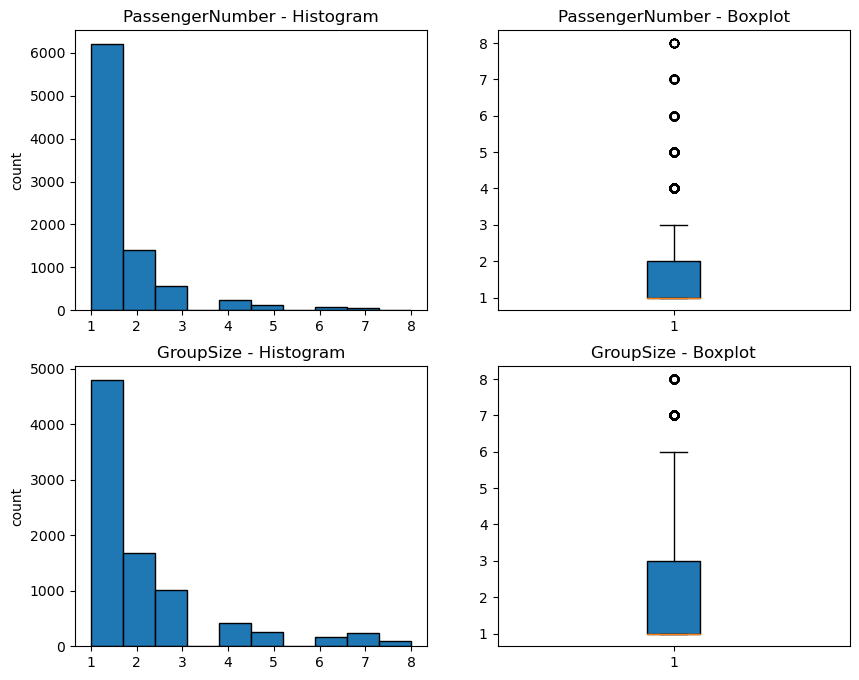

In [35]:
fig, [ax1, ax2] = plt.subplots(2,2)
fig.set_figheight(8)
fig.set_figwidth(10)

ax1[0].hist(train_data['PassengerNumber'], edgecolor='k')
ax1[0].set_title('PassengerNumber - Histogram')
ax1[0].set_ylabel('count')

ax1[1].boxplot(train_data['PassengerNumber'], patch_artist=True)
ax1[1].set_title('PassengerNumber - Boxplot')

ax2[0].hist(train_data['GroupSize'], edgecolor='k')
ax2[0].set_title('GroupSize - Histogram')
ax2[0].set_ylabel('count')

ax2[1].boxplot(train_data['GroupSize'], patch_artist=True)
ax2[1].set_title('GroupSize - Boxplot')

plt.show()

In [36]:
# converting these two columns (GroupSize and PassengerNumber) to categoricals and re-aggregate them

In [37]:
print('\nPassengerNumber value counts\n', train_data['PassengerNumber'].value_counts())
print('\nGroupSize value counts\n', train_data['GroupSize'].value_counts())


PassengerNumber value counts
 1    6217
2    1412
3     571
4     231
5     128
6      75
7      46
8      13
Name: PassengerNumber, dtype: int64

GroupSize value counts
 1.0    4805
2.0    1682
3.0    1020
4.0     412
5.0     265
7.0     231
6.0     174
8.0     104
Name: GroupSize, dtype: int64


In [38]:
def aggregating(x):
    if x == 1:
        return '1'
    elif x == 2 or x == 3:
        return '2 or 3'
    else:
        return '4+'

In [39]:
train_data['PassengerNumber'] = list(map(aggregating, train_data['PassengerNumber']))
train_data['GroupSize'] = list(map(aggregating, train_data['GroupSize']))
test_data['PassengerNumber'] = list(map(aggregating, test_data['PassengerNumber']))
test_data['GroupSize'] = list(map(aggregating, test_data['GroupSize']))

In [40]:
train_data.to_csv('../data/train_transformed.csv', index=None)
test_data.to_csv('../data/test_transformed.csv', index=None)